# SVM (Support Vector Machines)

Estimated time needed: **15-30** minutes

## Objectives

After completing this lab you will be able to:

*   Use scikit-learn to Support Vector Machine to classify


In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#load_dataset">Load the Cancer data</a></li>
        <li><a href="https://#modeling">Modeling</a></li>
        <li><a href="https://#evaluation">Evaluation</a></li>
        <li><a href="https://#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>


In [ ]:
!pip install scikit-learn==0.23.1

In [1]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])
await piplite.install(['numpy'])
await piplite.install(['scikit-learn'])
await piplite.install(['scipy'])


In [2]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

In [3]:
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, "wb") as f:
            f.write(await response.bytes())


<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the <a href="http://mlearn.ics.uci.edu/MLRepository.html">UCI Machine Learning Repository</a> (Asuncion and Newman, 2007). The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.

In [4]:
#Click here and press Shift+Enter
path="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"

## Load Data From CSV File


In [ ]:
await download(path, "cell_samples.csv")

In [23]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [24]:
cell_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           699 non-null    int64 
 1   Clump        699 non-null    int64 
 2   UnifSize     699 non-null    int64 
 3   UnifShape    699 non-null    int64 
 4   MargAdh      699 non-null    int64 
 5   SingEpiSize  699 non-null    int64 
 6   BareNuc      699 non-null    object
 7   BlandChrom   699 non-null    int64 
 8   NormNucl     699 non-null    int64 
 9   Mit          699 non-null    int64 
 10  Class        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


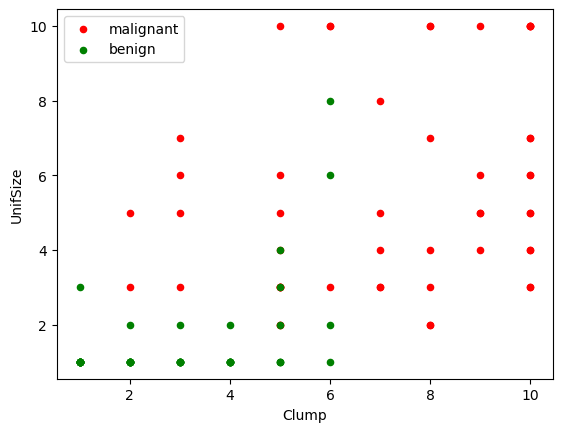

In [25]:
# filter 50 first malign samples
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='red', label='malignant')
# filter 50 first benign samples
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='green', label='benign', ax=ax)

plt.show()

## Data pre-processing and selection


Let's first look at columns data types:


In [26]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:


In [27]:
# Identify non-numeric values in the 'BareNuc' column
non_numeric_values = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').isnull()]

# Display the rows with non-numeric values
non_numeric_values

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
23,1057013,8,4,5,1,2,?,7,3,1,4
40,1096800,6,6,6,9,6,?,7,8,1,2
139,1183246,1,1,1,1,1,?,2,1,1,2
145,1184840,1,1,3,1,2,?,2,1,1,2
158,1193683,1,1,2,1,3,?,1,1,1,2
164,1197510,5,1,1,1,2,?,3,1,1,2
235,1241232,3,1,4,1,2,?,3,1,1,2
249,169356,3,1,1,1,2,?,3,1,1,2
275,432809,3,1,3,1,2,?,2,1,1,2
292,563649,8,8,8,1,2,?,6,10,1,4


In [28]:
# Get rid of non numeric values
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [38]:
# extract the features in a numpy array
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)  # df to a numpy array
print(X.shape)
X[0:5]  # print first 5 patients

(683, 9)


array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.


In [42]:
# extract the labels in a numpy array
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])  # serie to a numpy array
print(y.shape)
y[0:5]  # print the first 5 labels

(683,)


array([2, 2, 2, 2, 2])

## Train/Test dataset


We split our dataset into train and test set:


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)  # 20% ratio
print('Train set:', X_train.shape,  y_train.shape)
print('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

https://scikit-learn.org/stable/modules/svm.html  

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC


In [45]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')  # RBF used by default if not specified
clf.fit(X_train, y_train) 

SVC()

After being fitted, the model can then be used to predict new values:


In [57]:
yhat = clf.predict(X_test)
print("Predictions", yhat [0:20])
print("True Labels", y_test [0:20])

Predictions [2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2]
True Labels [2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2]


<h2 id="evaluation">Evaluation</h2>


In [54]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


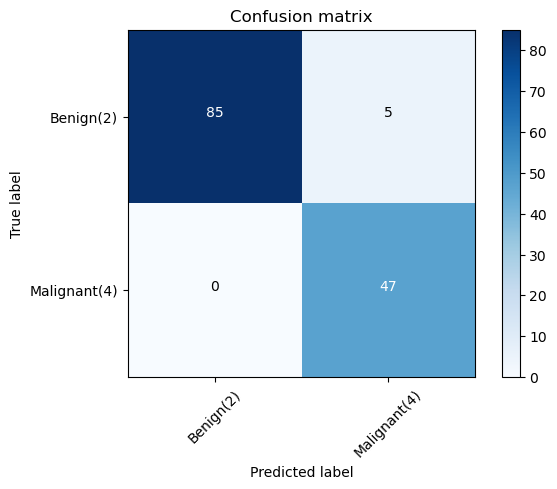

In [56]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

You can also easily use the **f1\_score** from sklearn library:


In [58]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Let's try the jaccard index for accuracy:

A and B are the true vs. predicted labels

The Jaccard Index is a valuable metric when you want to evaluate the overlap between predicted and actual values, especially for multi-label and imbalanced classification problems. It provides a more granular measure of performance compared to other metrics like accuracy, particularly when false positives and false negatives play a significant role in your model evaluation.


In [59]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label=2)

0.9444444444444444

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?


In [67]:
# write your code here

# create model with linear kernel
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_train, y_train)


SVC(kernel='linear')

In [68]:
# compare predictions
yhat_lin = clf_lin.predict(X_test)
print("Predictions", yhat_lin [0:20])
print("True Labels", y_test [0:20])

Predictions [2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2]
True Labels [2 4 2 4 2 2 2 2 4 2 2 4 4 4 4 2 2 2 2 2]


              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


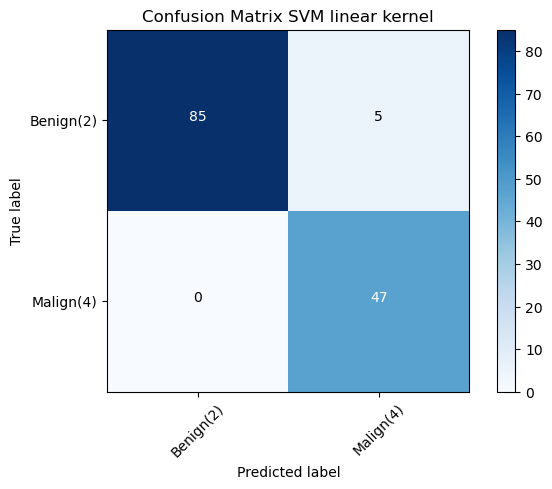

In [64]:
# Compute confusion matrix
cnf_lin_matrix = confusion_matrix(y_test, yhat_lin, labels=[2, 4])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat_lin))

plt.figure()
plot_confusion_matrix(cnf_lin_matrix, classes=['Benign(2)', 'Malign(4)'], normalize=False, title='Confusion Matrix SVM linear kernel')

In [65]:
# check f1_score and jaccard index
print("F1 score:", f1_score(y_test, yhat_lin, average='weighted'))
print("Jaccard Score:", jaccard_score(y_test, yhat_lin, pos_label=2))


F1 score: 0.9639038982104676
Jaccard Score: 0.9444444444444444


<details><summary>Click here for the solution</summary>

```python
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, yhat2,pos_label=2))

```

</details>


### Thank you for completing this lab!